Wget is a free software package for retrieving files using HTTP, HTTPS, FTP and FTPS the most widely-used Internet protocols. 

In [1]:
!pip install wget

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190625211352-0000
KERNEL_ID = 42ad7860-4e8e-4dd7-b23f-cfc8dbf77dcc
  Stored in directory: /home/spark/shared/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


### Download data from GitHub repositoy

In [2]:
import wget
url_test='https://raw.githubusercontent.com/Dylansafool/HandsOn-Notebook/master/churn-20.csv'
url_train='https://raw.githubusercontent.com/Dylansafool/HandsOn-Notebook/master/churn-80.csv'

### Remove existing files before downloading

In [3]:
!rm -f churn-20.csv
!rm -f churn-80.csv

test_Filename=wget.download(url_test)
train_Filename=wget.download(url_train)

!ls -l churn-20.csv
!ls -l churn-80.csv

-rw-r--r-- 1 spark spark 53842 Jun 25 21:14 churn-20.csv
-rw-r--r-- 1 spark spark 213803 Jun 25 21:14 churn-80.csv


### Import the dataset
For this tutorial, we'll be using a Telecoms Churn Dataset. It consists of cleaned customer activity data (features), along with a churn label specifying whether the customer canceled their subscription or not. The two data sets churn-80 and churn-20 are from the same batch, but have been split by an 80/20 ratio. We'll use the larger set for training and cross-validation purposes, and the smaller set for final testing and model performance evaluation. The two data sets have been included in this repository for convenience.

Let's load the two CSV data sets into Spark DataFrames.

In [23]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
CV_data = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferschema', 'true')\
  .load('churn-80.csv')

final_test_data = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferschema', 'true')\
  .load('churn-20.csv')

Print the schema of training data

In [24]:
CV_data.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: integer (nullable = true)



By taking 5 rows of the CV_data variable and generating a Pandas DataFrame with them, we can get a display of what the rows look like. We're using Pandas instead of the Spark DataFrame.show() function because it creates a prettier print.

In [25]:
import pandas as pd
pd.DataFrame(CV_data.take(5), columns=CV_data.columns)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


### Summary Statistics

Spark DataFrames include some built-in functions for statistical processing. The describe() function performs summary statistics calculations on all numeric columns, and returns them as a DataFrame.

In [26]:
CV_data.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
State,2666,None,None,AK,WY
Account length,2666,100.62040510127532,39.56397365334985,1,243
Area code,2666,437.43885971492875,42.521018019427174,408,510
International plan,2666,None,None,No,Yes
Voice mail plan,2666,None,None,No,Yes
Number vmail messages,2666,8.021755438859715,13.61227701829193,0,50
Total day minutes,2666,179.48162040510135,54.21035022086982,0.0,350.8
Total day calls,2666,100.31020255063765,19.988162186059512,0,160
Total day charge,2666,30.512404351087813,9.215732907163497,0.0,59.64


### Correlations and Data Preparation

We can also perform our own statistical analyses, using the MLlib statistics package or other python packages. Here, we're using the Pandas library to examine correlations between the numeric columns by generating scatter plots of them.

For the Pandas workload, we don't want to pull the entire data set into the Spark driver, as that might exhaust the available RAM and throw an out-of-memory exception. Instead, we'll randomly sample a portion of the data (say 10%) to get a rough idea of how it looks.

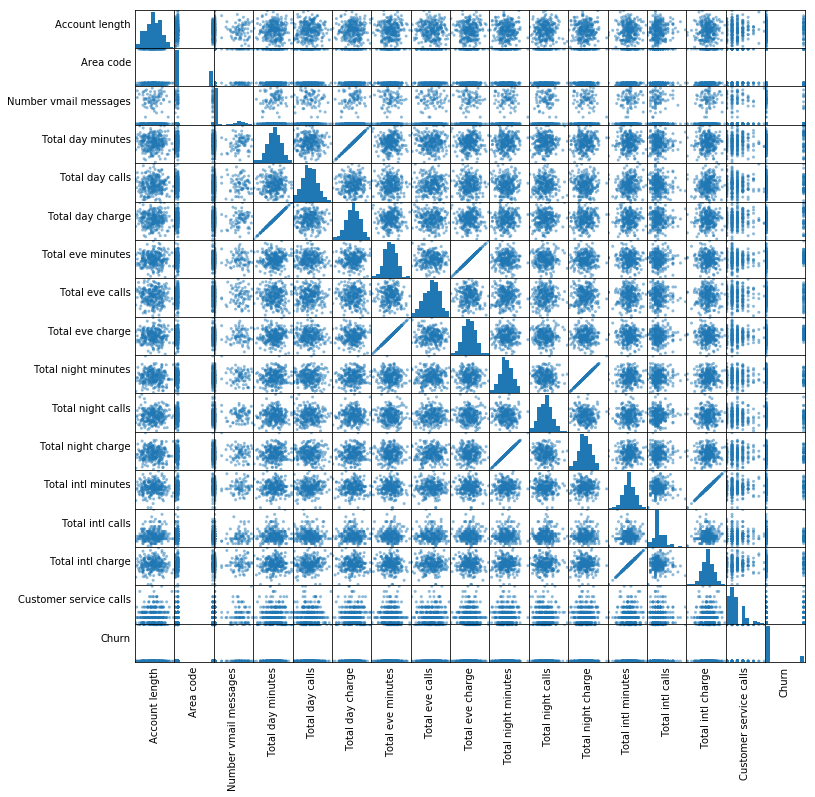

In [27]:
from pandas.plotting import scatter_matrix

numeric_features = [t[0] for t in CV_data.dtypes if t[1] == 'int' or t[1] == 'double']

sampled_data = CV_data.select(numeric_features).sample(False, 0.10).toPandas()

axs = scatter_matrix(sampled_data, figsize=(12, 12));

# Rotate axis labels and remove axis ticks
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

It's obvious that there are several highly correlated fields, ie *Total day minutes* and *Total day charge*. Such correlated data won't be very beneficial for our model training runs, so we're going to remove them. We'll do so by dropping one column of each pair of correlated fields, along with the *State* and *Area code columns*.

While we're in the process of manipulating the data sets, let's transform the categorical data into numeric as required by the machine learning routines, using a simple user-defined function that maps Yes and No to 1 and 0, respectively.

### Data Transformation
Transform the categorical data into numeric as required by the machine learning routines
Use a simple user-defined function that maps Yes/True and No/False to 1 and 0, respectively.

In [9]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import UserDefinedFunction

binary_map = {'Yes':1.0, 'No':0.0}
toNum = UserDefinedFunction(lambda k: binary_map[k], DoubleType())

CV_data = CV_data.drop('State').drop('Area code') \
    .drop('Total day charge').drop('Total eve charge') \
    .drop('Total night charge').drop('Total intl charge') \
    .withColumn('International plan', toNum(CV_data['International plan'])) \
    .withColumn('Voice mail plan', toNum(CV_data['Voice mail plan']))

final_test_data = final_test_data.drop('State').drop('Area code') \
    .drop('Total day charge').drop('Total eve charge') \
    .drop('Total night charge').drop('Total intl charge') \
    .withColumn('International plan', toNum(final_test_data['International plan'])) \
    .withColumn('Voice mail plan', toNum(final_test_data['Voice mail plan']))

Let's take a quick look at the resulting data set.

In [10]:
pd.DataFrame(CV_data.take(5), columns=CV_data.columns)

,Account length,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls,Churn
0,128,0.0,1.0,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,107,0.0,1.0,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,137,0.0,0.0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,84,1.0,0.0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,75,1.0,0.0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0


## Using the Spark ML Package

The Spark ML package is the newer library of machine learning routines. It provides an API for pipelining data transformers, estimators and model selectors. We'll use it here to perform cross-validation across several decision trees with various maxDepth parameters in order to find the optimal model.

### Decision Tree Models

Decision trees have played a significant role in data mining and machine learning since the 1960's. They generate white-box classification and regression models which can be used for feature selection and sample prediction. The transparency of these models is a big advantage over black-box learners, because the models are easy to understand and interpret, and they can be readily extracted and implemented in any programming language (with nested if-else statements) for use in production environments. Furthermore, decision trees require almost no data preparation (ie normalization) and can handle both categorical and continuous data. To remedy over-fitting and improve prediction accuracy, decision trees can also be limited to a certain depth or complexity, or bundled into ensembles of trees (ie random forests).

### Stratified Sampling

Let's try grouping the CV_data DataFrame by the Churn field and counting the number of instances in each group.

In [11]:
CV_data.groupby('Churn').count().toPandas()

,Churn,count
0,1,388
1,0,2278


There are roughly 6 times as many 0 (False) churn samples as 1 (True) churn samples. We can put the two sample types on the same footing using stratified sampling. The DataFrames sampleBy() function does this when provided with fractions of each sample type to be returned.

Here we're keeping all instances of the Churn=1 (True) class, but downsampling the Churn=0 (False) class to a fraction of 388/2278.

In [12]:
stratified_CV_data = CV_data.sampleBy('Churn', fractions={0: 388./2278, 1: 1.0})

stratified_CV_data.groupby('Churn').count().toPandas()

,Churn,count
0,1,388
1,0,361


### Pipelining
The ML package needs data be put in a (label: integer, features: Vector) DataFrame format with correspondingly named fields. The vectorizeData( ) function below performs this formatting.

Next we'll pass the data through a pipeline of two transformers, StringIndexer( ) and VectorIndexer( ) which index the label and features fields respectively. Indexing categorical features allows decision trees to treat categorical features appropriately, improving performance. The final element in our pipeline is an estimator (a decision tree classifier) training on the indexed labels and features.

In [13]:
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def vectorizeData(data):
    return data.rdd.map(lambda r: [r[-1], Vectors.dense(r[:-1])]).toDF(['label','features'])

vectorized_CV_data = vectorizeData(stratified_CV_data)

Index labels, adding metadata to the label column

In [14]:
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(vectorized_CV_data)

Automatically identify categorical features and index them

In [15]:
featureIndexer = VectorIndexer(inputCol='features',
                               outputCol='indexedFeatures',
                               maxCategories=2).fit(vectorized_CV_data)

Train a DecisionTree model

In [16]:
dTree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

Chain indexers and tree in a Pipeline

In [17]:
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dTree])

Search through decision tree's maxDepth parameter for best model

In [18]:
paramGrid = ParamGridBuilder().addGrid(dTree.maxDepth, [2,3,4,5,6,7]).build()

Set F-1 score as evaluation metric for best model selection

In [19]:
evaluator = MulticlassClassificationEvaluator(labelCol='indexedLabel',
                                              predictionCol='prediction', metricName='f1')

Set up 3-fold cross validation, fetch best model

In [20]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

CV_model = crossval.fit(vectorized_CV_data)

tree_model = CV_model.bestModel.stages[2]
print (tree_model)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4e92a2076797d020b0f4) of depth 5 with 51 nodes


### Predictions and Model Evaluation
The actual performance of the model can be determined using the final_test_data set which has not been used for any training or cross-validation activities. We'll transform the test set with the model pipeline, which will map the labels and features according to the same recipe. The evaluator will provide us with the F-1 score of the predictions, and then we'll print them along with their probabilities. Predictions on new, unlabeled customer activity data can also be made using the same pipeline CV_model.transform() function.

In [21]:
vectorized_test_data = vectorizeData(final_test_data)

transformed_data = CV_model.transform(vectorized_test_data)
print (evaluator.getMetricName(), 'accuracy:', evaluator.evaluate(transformed_data))

predictions = transformed_data.select('indexedLabel', 'prediction', 'probability')
predictions.toPandas().head()

f1 accuracy: 0.902277122308411


,indexedLabel,prediction,probability
0,1.0,1.0,"[0.18828451882845187, 0.8117154811715481]"
1,0.0,0.0,"[1.0, 0.0]"
2,0.0,0.0,"[1.0, 0.0]"
3,1.0,1.0,"[0.060240963855421686, 0.9397590361445783]"
4,1.0,1.0,"[0.18828451882845187, 0.8117154811715481]"


The prediction probabilities can be very useful in ranking customers by their likeliness to defect. This way, the limited resources available to the business for retention can be focused on the appropriate customers.